In [1]:
! pip install pygeohash
! pip install folium

In [2]:
import matplotlib.pyplot as plt
import json
from pymongo import MongoClient
from kafka3 import KafkaConsumer
import pygeohash as pgh
from datetime import datetime
from pprint import pprint
import folium
%matplotlib notebook

In [3]:
host_ip = "YOUR IP"
topic = "Climate"

In [4]:
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=100000, # stop iteration if no message after 100 sec
                                   bootstrap_servers=[f'{host_ip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

These function is from lab, modified a bit for this assignment

In [5]:
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Date={}, Air Temp={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Date={}, Air Temp={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

In [6]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Air Temperature Against Arrival Time') 
        ax.set_xlabel('Date')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,60) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [7]:
def consume_messages(consumer, fig, ax):
    x, y = [], []
    try:
        for message in consumer:
            data = json.loads(message.value)
            new_time = datetime.strptime(data["datetime"], "%d/%m/%Y %H:%M:%S")
            new_air_temp = data["climate"]["air_temperature_celcius"]
            x.append(new_time)
            y.append(new_air_temp)
            
            ##now to plot
            if len(y) > 5:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Date')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,60) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0)
                y.pop(0)
        plt.close('all')
        
        
    except Exception as ex:
        print(str(ex))

Start receiving message and plot

<IPython.core.display.Javascript object>


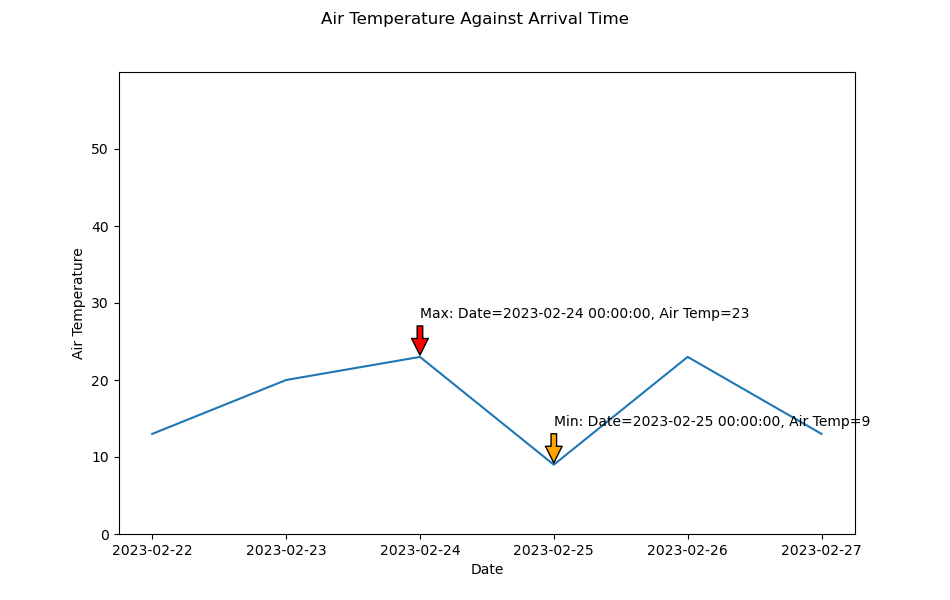

KeyboardInterrupt: 

In [8]:
consumer = connect_kafka_consumer()
fig, ax = init_plots()
consume_messages(consumer,fig,ax)

Now we want to plot the number of fire for each hour, first lets make a query to our database(assume that we already process some data from previous streaming)

In [9]:
ip_address = "YOUR IP"
client = MongoClient(f"{ip_address}", 27017)
db = client.fit3182_assignment_db
collection = db.overwatch

The trick here is to get the hour from the datetime object before grouping them by hour and perform counting

In [10]:
fire_per_hour = [0] * 24
query_1 = collection.aggregate([{"$unwind" : "$hotspot_data"}, {"$project" : {"hour" : {"$hour" : "$hotspot_data.datetime"}}}, {"$group" : {"_id" : "$hour", "number_of_fire" :{ "$count" : {} }}}])

for i in query_1:
    fire_per_hour[i["_id"]] = i["number_of_fire"]
    pprint(i)

{'_id': 9, 'number_of_fire': 3}


Now to check whether we have put in the data correctly into the array

In [11]:
fire_per_hour

[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Plot the total number of fire records per hour

<IPython.core.display.Javascript object>


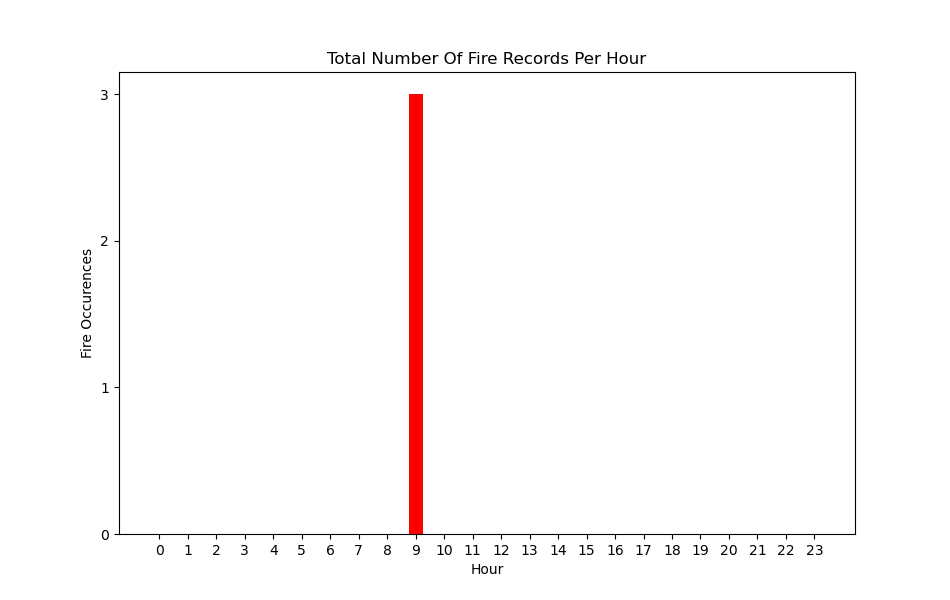

In [12]:
hour_x = [i for i in range(24)]
fig = plt.figure(figsize = (9.5, 6))
plt.bar(hour_x, fire_per_hour, color = "red", width = 0.5)

plt.xlabel("Hour")
plt.ylabel("Fire Occurences")
plt.title("Total Number Of Fire Records Per Hour")
plt.yticks(range(max(fire_per_hour)+1))
plt.xticks(range(24))
plt.show()

Now to visualize all the fire events using folium, first we create another query to get all the fire events

In [13]:
fire_events = []
query_2 = collection.find({"hotspot_data" : {"$ne" : None}})
for i in query_2:
    fire_events.append(i) ##if not printing just use extend
    pprint(i)

{'GHI_w/m2': 178,
 '_id': ObjectId('647de66eadc290cd46c9f374'),
 'air_temperature_celcius': 23,
 'date': datetime.datetime(2023, 3, 2, 0, 0),
 'hotspot_data': [{'confidence': 84.5,
                   'date': datetime.datetime(2023, 3, 2, 0, 0),
                   'datetime': datetime.datetime(2023, 3, 2, 9, 36),
                   'fire_cause': 'other',
                   'latitude': -37.7216,
                   'longitude': 143.4272,
                   'surface_temperature_celcius': 58.5}],
 'max_wind_speed': 15.9,
 'precipitation ': ' 0.00I',
 'precipitation_type': 'I',
 'precipitation_value': 0.0,
 'relative_humidity': 61.9,
 'station': '12345',
 'windspeed_knots': 8.0}
{'GHI_w/m2': 134,
 '_id': ObjectId('647de6dcadc290cd46c9f38a'),
 'air_temperature_celcius': 14,
 'date': datetime.datetime(2023, 3, 13, 0, 0),
 'hotspot_data': [{'confidence': 61.0,
                   'date': datetime.datetime(2023, 3, 13, 0, 0),
                   'datetime': datetime.datetime(2023, 3, 13, 9, 36),
 

Initialize the map in one of the location

In [14]:
init_lat = fire_events[0]["hotspot_data"][0]["latitude"]
init_long = fire_events[0]["hotspot_data"][0]["longitude"]
fomap = folium.Map(location=[init_lat, init_long], zoom_start=7)

Now go through each climate data, get all the fire events, mark them in the map

In [15]:
for climate in fire_events:
    for hotspot_data in climate["hotspot_data"]:
        lat = hotspot_data["latitude"]
        long = hotspot_data["longitude"]
        air_temp = climate["air_temperature_celcius"]
        surface_temp = hotspot_data["surface_temperature_celcius"]
        relative_humidity = climate["relative_humidity"]
        confidence = hotspot_data["confidence"]
        icon_color = "blue" if hotspot_data["fire_cause"] == "natural" else "red"
        popup_string = f"air temp : {air_temp}, surface_temp : {surface_temp}, relative humidity : {relative_humidity}, confidence : {confidence}"
        folium.Marker(location=[lat,long], popup=popup_string, icon=folium.Icon(color = icon_color)).add_to(fomap)    

In [16]:
fomap